# Amazon Ratings Recommendation System 

## Define

The Amazon beauty ratings dataset can be obtained from Kaggle - 
https://www.kaggle.com/skillsmuggler/amazon-ratings?select=ratings_Beauty.csv

Dataset consists of Userid's, Ratings, Product id and timestamp. Dataset contains more than 2M records. 

Amazon, Netflix and a lot of organizations are currently relying on Recommendation systems to suggest products to a user. 

Recommendation systems can be based on content, item/user based and model based. 

Content based recommendation systems rely on analyzing the content and suggesting products that have similar content. 
The major drawback is only products that are very similar to each other are recommended. 

User based recommendation systems rely on understanding how one user is similar to the other based on the product ratings/products viewed etc. 
Major drawback is often users tend to change their opinions and if the user is new to the product then there is no data to support the recommendations. 

Item based recommendation systems rely on understanding how one item/product is related to the other. Based on their porpularity, rating etc. 
Major drawback is not all items have ratings and if the product is new then there is no data to support the recommendations. 

Model based recommendation systems rely on matrix factorization approach where all the relationships between users and items are condensed and converted into two separate vectors.
This approach resolves the issues of user based and item based recommendation systems. 


## Objective

Create a simple recommendation system.

In [1]:
#importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics.pairwise as pw
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
import warnings
warnings.filterwarnings('ignore')

__author__ = "Sai Jyothi Gurram"
__email__ = "jyothisai1993@gmail.com"

All the necessary libraries are imported. 

## Loading the data

In [3]:
#loading the data into a dataframe 
ratings = pd.read_csv('ratings_Beauty.csv')

In [4]:
#checking the size of the data 
ratings.shape

(2023070, 4)

In [5]:
#checking the columns
ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


## Cleaning the data 

In [7]:
#removing timestamp from the ratings dataframe 
ratings.drop(['Timestamp'],axis =1,inplace = True)

Dropping the timestamp column for easier analysis 

In [8]:
#checking for null values 
ratings.isnull().any()

UserId       False
ProductId    False
Rating       False
dtype: bool

Clearly there are no null values in the data 

In [9]:
#removing duplicates
ratings.drop_duplicates().shape

(2023070, 3)

Clearly there are no duplicates as well

## Data Exploration 

In [10]:
#understanding average rating 
ratings['Rating'].describe()

count    2.023070e+06
mean     4.149036e+00
std      1.311505e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

Average rating is 4.1 

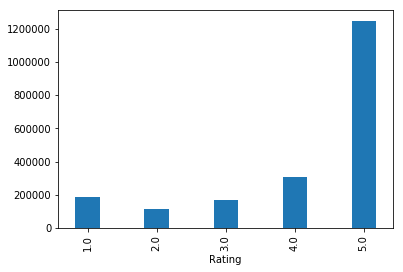

In [11]:
#rating distribution 
width = 0.35
ratings.groupby('Rating')['UserId'].count().plot(kind = "bar", width = width)

Clearly most of the users gave 5 rating

In [12]:
#creating dataframes for average rating and user count
product_mean  = ratings.groupby('ProductId')['Rating'].mean()
product_count = ratings.groupby('ProductId')['Rating'].count()

In [13]:
#combining mean and value counts at product level
product = pd.merge(product_mean, product_count, on ='ProductId')

In [14]:
#sorting the user counts 
product = product.sort_values(['Rating_y'] , ascending= False)

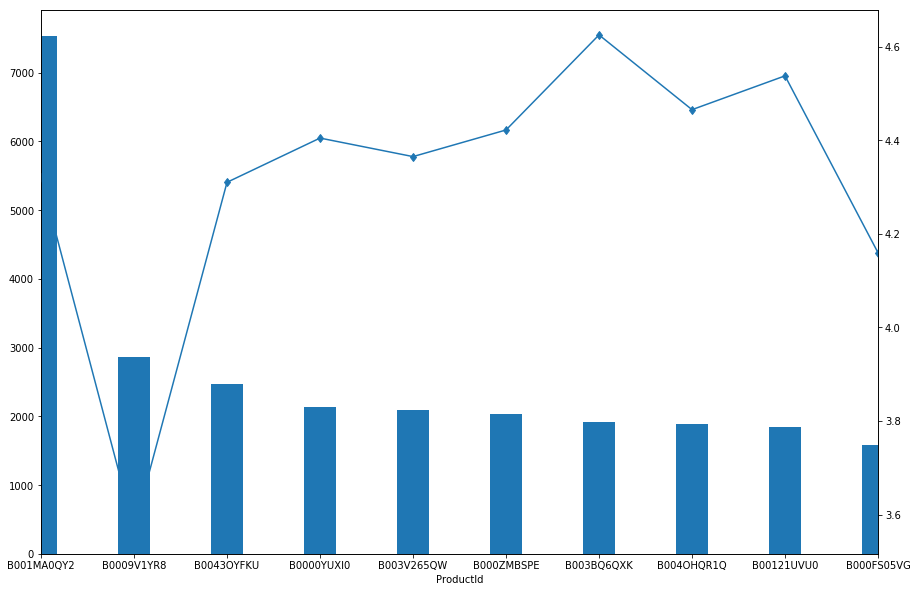

In [15]:
#plotting a graph between count and rating 
width = 0.35
fig, ax1 = plt.subplots(figsize=(15, 10))
product['Rating_y'].head(10).plot(kind = "bar", width = width)
product['Rating_x'].head(10).plot(kind = 'line', marker = 'd',secondary_y=True)

Even though the first two products have the highest number of ratings, the average rating is less compared to other products

In [16]:
#creating new dataframe with user counts
df = ratings['ProductId'].value_counts()

In [17]:
#subsetting the data for computational reasons 
#selecting top 100 products 
appended_data = []
for i in df.head(100).index:
        rating = ratings[ratings['ProductId'] == i]  
        appended_data.append(rating)
        
appended_data = pd.concat(appended_data)

In [18]:
#checking the size of the data 
appended_data.shape

(107098, 3)

Converting the subsetted data into a Pivot table 

In [19]:
#converting the dataframe into pivot table 
pivot = appended_data.pivot_table(values='Rating', index='UserId', columns='ProductId')
#transposing the data
pivot_product = pivot.T

In [20]:
#understanding the shapes of the dataframes
print(pivot.shape)
print(pivot_product.shape)

(99361, 100)
(100, 99361)


In [21]:
#similarity matrix function 
def similarity_matrix(data,i):
    sparse_pivot = sparse.csr_matrix(data.fillna(0))
    #calculating the cosine similarity between product to product 
    recommender = pw.cosine_similarity(sparse_pivot)
    #creating dataframe 
    recommender_df = pd.DataFrame(recommender, 
                                  columns=data.index,
                                  index=data.index)
    #randomly chose this product 
    df = pd.DataFrame(recommender_df.iloc[i].sort_values(ascending=False))
    df.reset_index(level=0, inplace=True)
    df.columns = ['title','similarity']
    #recommend top 4 products 
    print('Recommended Products for product:',df['title'].head(1))
    print('\n are:',df['title'].head(5))
      

In [22]:
# calling similarity matrix 
similarity_matrix(pivot_product,10)

Recommended Products for product: 0    B0009FHJRS
Name: title, dtype: object

 are: 0    B0009FHJRS
1    B002JPJ2ZS
2    B000UVZU1S
3    B003UH0528
4    B006L1DNWY
Name: title, dtype: object


For the product B0009FHJRS the products  B002JPJ2ZS, B000UVZU1S, B003UH0528, B006L1DNWY are recommended 

In [26]:
#similarity matrix function 
from sklearn.decomposition import TruncatedSVD
def SVD_similarity_matrix(data,i):
    sparse_pivot = sparse.csr_matrix(data.fillna(0))
    #selecting 10 components 
    svd = TruncatedSVD(n_components=10)
    decomposed_matrix = svd.fit_transform(sparse_pivot)
    #calculating correlations
    correlation_matrix = np.corrcoef(decomposed_matrix)
    #creating dataframe 
    SVD_corr = pd.DataFrame(correlation_matrix, 
                                  columns=data.index,
                                  index=data.index)
    #randomly chose this product 
    df = pd.DataFrame(SVD_corr.iloc[i].sort_values(ascending=False))
    df.reset_index(level=0, inplace=True)
    df.columns = ['title','similarity']
    #recommend top 4 products 
    print('Recommended Products for product:',df['title'].head(1))
    print('\n are:',df['title'].head(5))
    
    

In [27]:
# calling SVD similarity matrix 
SVD_similarity_matrix(pivot_product,10)

Recommended Products for product: 0    B0009FHJRS
Name: title, dtype: object

 are: 0    B0009FHJRS
1    B0009OAGXI
2    B000L596FE
3    B00121UVU0
4    B00639DLV2
Name: title, dtype: object


Based on the model for product B0009FHJRS : B0009OAGXI, B000L596FE, B00121UVU0, B00639DLV2 are recommended. 

## Summary

The model based recommendation system can now be used to recommend products. 
The sparsity and scalability issue of user based/item based systems has been resolved in model based system. 